Suyash Tambe  22070126117 AIML B2

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"


100%|██████████| 170M/170M [00:12<00:00, 13.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
# Define Autoencoder (AE)
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64*64*3, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 64*64*3),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.view(x.size(0), 3, 64, 64)


In [5]:
# Define Variational Autoencoder (VAE)
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64*64*3, 512),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 64*64*3),
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.encoder(x)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder(z)
        return decoded.view(x.size(0), 3, 64, 64), mu, logvar

In [6]:
# Train Autoencoder
def train_autoencoder(model, dataloader, epochs=10, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.to(device)

    for epoch in range(epochs):
        for images, _ in dataloader:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    return model

In [7]:
# Train Variational Autoencoder
def train_vae(model, dataloader, epochs=10, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    def vae_loss(recon_x, x, mu, logvar):
        recon_loss = nn.MSELoss()(recon_x, x)
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kl_divergence

    for epoch in range(epochs):
        for images, _ in dataloader:
            images = images.to(device)
            recon_images, mu, logvar = model(images)
            loss = vae_loss(recon_images, images, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    return model


Epoch [1/10], Loss: 0.0280
Epoch [2/10], Loss: 0.0197
Epoch [3/10], Loss: 0.0217
Epoch [4/10], Loss: 0.0251
Epoch [5/10], Loss: 0.0214
Epoch [6/10], Loss: 0.0206
Epoch [7/10], Loss: 0.0177
Epoch [8/10], Loss: 0.0174
Epoch [9/10], Loss: 0.0147
Epoch [10/10], Loss: 0.0190
Visualizing Autoencoder Reconstruction


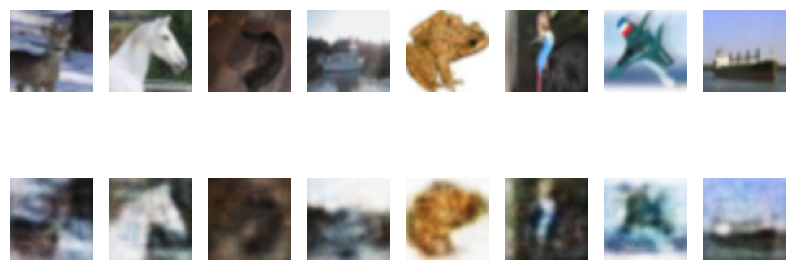

Epoch [1/10], Loss: 6.5653
Epoch [2/10], Loss: 1.3779
Epoch [3/10], Loss: 0.3987
Epoch [4/10], Loss: nan
Epoch [5/10], Loss: nan
Epoch [6/10], Loss: nan
Epoch [7/10], Loss: nan
Epoch [8/10], Loss: nan
Epoch [9/10], Loss: nan
Epoch [10/10], Loss: nan
Visualizing Variational Autoencoder Reconstruction


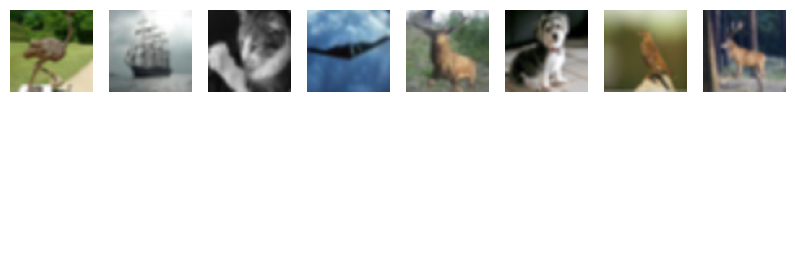

In [8]:

# Visualization Function
def visualize_reconstruction(model, dataloader, is_vae=False):
    model.eval()
    images, _ = next(iter(dataloader))
    images = images.to(device)
    with torch.no_grad():
        if is_vae:
            reconstructed, _, _ = model(images)
        else:
            reconstructed = model(images)

    fig, axes = plt.subplots(2, 8, figsize=(10, 4))
    for i in range(8):
        axes[0, i].imshow(images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
        axes[1, i].axis('off')
    plt.show()

# Train and visualize Autoencoder
ae = Autoencoder(latent_dim=128)
ae = train_autoencoder(ae, dataloader)
print("Visualizing Autoencoder Reconstruction")
visualize_reconstruction(ae, dataloader)

# Train and visualize Variational Autoencoder
vae = VariationalAutoencoder(latent_dim=128)
vae = train_vae(vae, dataloader)
print("Visualizing Variational Autoencoder Reconstruction")
visualize_reconstruction(vae, dataloader, is_vae=True)
